In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Set display options
np.set_printoptions(precision=10, threshold=np.inf)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)
pd.options.display.float_format = '{:.10f}'.format

# Load the dataset
file_path = '/Data/sample_v10.csv'
data = pd.read_csv(file_path)
print(data.head())

             x1            x2             x3            x4            x5            x6             x7             x8             x9            x10        y
0 10.0071000000 -3.8675000000   6.6899000000 33.1367000000 24.3674000000 -1.7803000000  -1.2021000000 -49.9108000000 -35.0150000000 -69.6709000000  Bicycle
1  4.0799000000  5.3650000000  22.6921000000  5.8840000000 -7.3794000000  9.4086000000 -47.1878000000 -26.5750000000  90.0186000000  51.9291000000     Walk
2  4.4219000000 -5.1384000000  19.9140000000 30.2850000000 18.3257000000 -7.5855000000  -4.9785000000 -43.7822000000  27.4785000000 -24.0543000000  Bicycle
3  2.4046000000  1.0938000000 -22.8637000000 47.5924000000  4.2035000000 29.6571000000  22.1897000000  -9.1959000000  75.0079000000   4.3526000000     Taxi
4 -3.1989000000 10.1843000000  -9.7620000000 -7.9439000000  2.7512000000  5.4564000000 -20.1493000000  -3.7285000000   9.7938000000  16.1566000000      Bus


In [2]:
# Check for missing values
print("Missing values in dataset:")
print(data.isnull().sum())

Missing values in dataset:
x1     0
x2     0
x3     0
x4     0
x5     0
x6     0
x7     0
x8     0
x9     0
x10    0
y      0
dtype: int64


In [3]:
# Encode the target variable
label_encoder = LabelEncoder()
data['y_encoded'] = label_encoder.fit_transform(data['y'])

# Separate features (X) and target (y)
X = data.drop(columns=['y', 'y_encoded'])
y = data['y_encoded']

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=20231225
)

# Verify stratified split
print("Training Set Shape:", X_train.shape)
print("Testing Set Shape:", X_test.shape)
print("Training Set Target Distribution:\n", y_train.value_counts(normalize=True))
print("Testing Set Target Distribution:\n", y_test.value_counts(normalize=True))

Training Set Shape: (19259, 10)
Testing Set Shape: (8254, 10)
Training Set Target Distribution:
 y_encoded
0   0.2668362843
4   0.2324108209
3   0.2309569552
1   0.1352614362
2   0.1345345033
Name: proportion, dtype: float64
Testing Set Target Distribution:
 y_encoded
0   0.2669008965
4   0.2323721832
3   0.2309183426
1   0.1353283257
2   0.1344802520
Name: proportion, dtype: float64


In [4]:
# Mapping encoded values to their original labels
category_mapping = dict(enumerate(label_encoder.classes_))
print("Category Mapping:", category_mapping)

# Display the relative frequencies with category names
training_distribution = y_train.value_counts(normalize=True).rename(index=category_mapping)
testing_distribution = y_test.value_counts(normalize=True).rename(index=category_mapping)

print("\nTraining Set Target Distribution (with Categories):\n", training_distribution)
print("\nTesting Set Target Distribution (with Categories):\n", testing_distribution)


Category Mapping: {0: 'Bicycle', 1: 'Bus', 2: 'Others', 3: 'Taxi', 4: 'Walk'}

Training Set Target Distribution (with Categories):
 y_encoded
Bicycle   0.2668362843
Walk      0.2324108209
Taxi      0.2309569552
Bus       0.1352614362
Others    0.1345345033
Name: proportion, dtype: float64

Testing Set Target Distribution (with Categories):
 y_encoded
Bicycle   0.2669008965
Walk      0.2323721832
Taxi      0.2309183426
Bus       0.1353283257
Others    0.1344802520
Name: proportion, dtype: float64


In [5]:
# Step 1: Determine optimal tree depth using cross-validation
depths = range(1, 21)
train_accuracies = []
test_accuracies = []
cv_scores = []

for depth in depths:
    tree = DecisionTreeClassifier(criterion="entropy", random_state=20231225, max_depth=depth)
    tree.fit(X_train, y_train)
    train_accuracies.append(tree.score(X_train, y_train))
    test_accuracies.append(tree.score(X_test, y_test))
    cv_scores.append(np.mean(cross_val_score(tree, X_train, y_train, cv=5, scoring='accuracy')))

optimal_depth = depths[np.argmax(cv_scores)]
print(f"Optimal Depth (Cross-Validation): {optimal_depth}")

Optimal Depth (Cross-Validation): 7


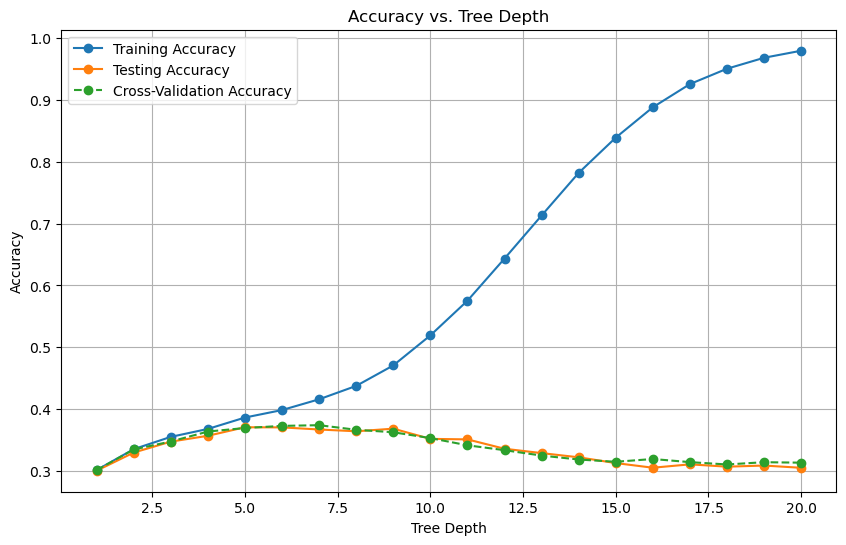

In [7]:
# Plot accuracy vs depth
plt.figure(figsize=(10, 6))
plt.plot(depths, train_accuracies, label="Training Accuracy", marker='o')
plt.plot(depths, test_accuracies, label="Testing Accuracy", marker='o')
plt.plot(depths, cv_scores, label="Cross-Validation Accuracy", linestyle='--', marker='o')
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Tree Depth")
plt.legend()
plt.grid()
plt.show()

In [25]:
# Step 2: Train and evaluate the decision tree with optimal depth
tree = DecisionTreeClassifier(criterion="entropy", random_state=20231225, max_depth=6)
tree.fit(X_train, y_train)


DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=20231225)

In [27]:
# Predict on the test set
y_pred = tree.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy with Depth {optimal_depth}: {test_accuracy:.2%}")


Test Accuracy with Depth 7: 37.05%


In [29]:
# Step 3: Predict probabilities for testing partition
y_pred_proba = tree.predict_proba(X_test)

# Display predicted probabilities
predicted_probabilities = pd.DataFrame(
    y_pred_proba,
    columns=label_encoder.classes_,
    index=X_test.index
).head(10)  # Display first 10 probabilities for clarity
print("Predicted Probabilities (First 10 Rows):")
print(predicted_probabilities)


Predicted Probabilities (First 10 Rows):
           Bicycle          Bus       Others         Taxi         Walk
10250 0.4054054054 0.0918918919 0.0432432432 0.1945945946 0.2648648649
4630  0.3097345133 0.0619469027 0.0796460177 0.2256637168 0.3230088496
23147 0.4022346369 0.1396648045 0.0279329609 0.1396648045 0.2905027933
15411 0.1046511628 0.4728682171 0.0000000000 0.0232558140 0.3992248062
24161 0.1046511628 0.4728682171 0.0000000000 0.0232558140 0.3992248062
18504 0.3724373576 0.0592255125 0.0842824601 0.2665148064 0.2175398633
14856 0.0579710145 0.5000000000 0.0000000000 0.0000000000 0.4420289855
973   0.3099787686 0.0297239915 0.1518046709 0.3290870488 0.1794055202
13142 0.3099787686 0.0297239915 0.1518046709 0.3290870488 0.1794055202
6333  0.4235807860 0.0786026201 0.0669577875 0.1906841339 0.2401746725


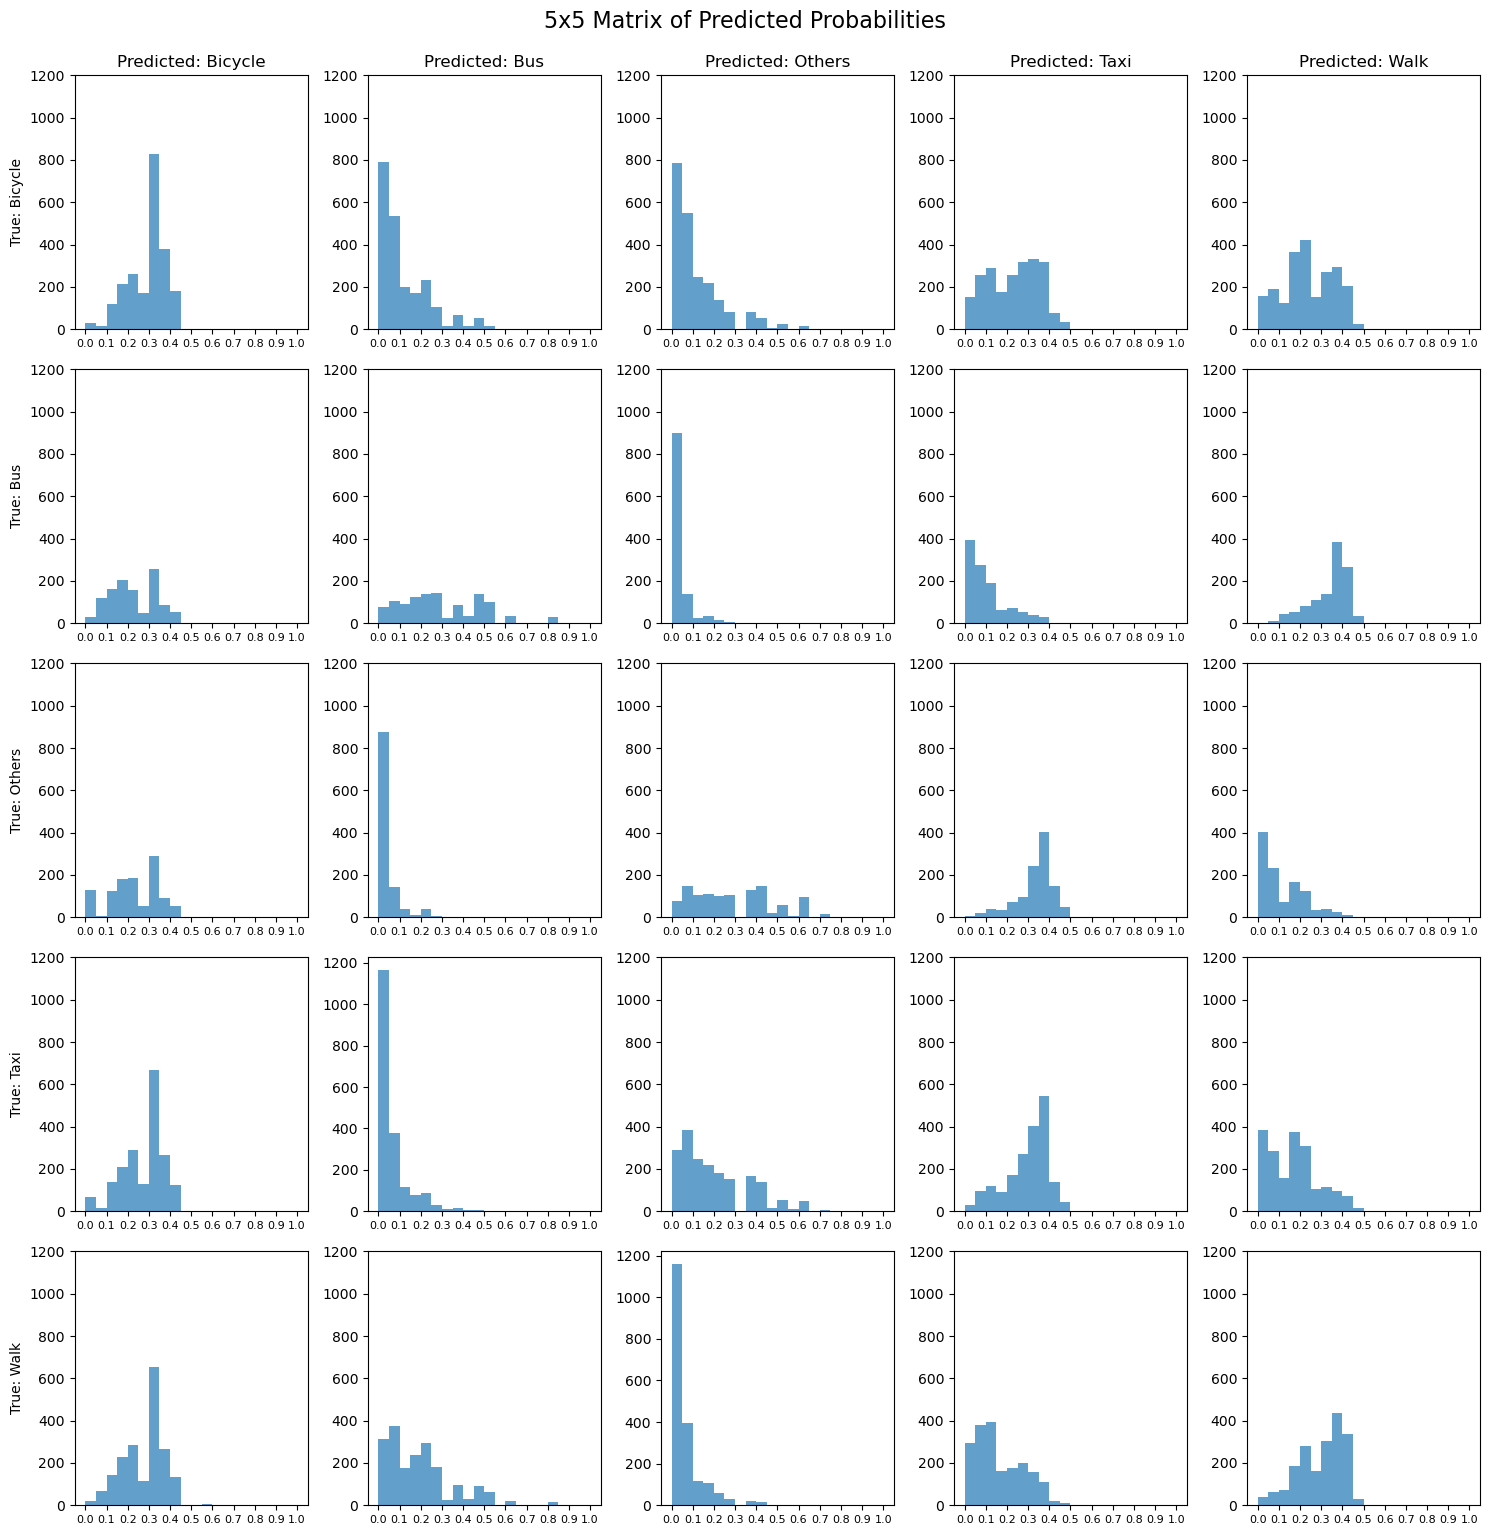

In [53]:
# Step 4: Create labeled histograms for predicted probabilities
class_names = label_encoder.classes_  # Class names from the encoder
plt.figure(figsize=(15, 15))  # Set figure size for clarity

bin_width = 0.05  # Set bin width to 0.05
number_of_bins = int((1 - 0) / bin_width)  # Calculate the number of bins

# Iterate over rows (true labels)
for i, true_label in enumerate(class_names):
    true_indices = np.where(y_test == i)[0]  # Get indices where the true label matches
    true_probabilities = y_pred_proba[true_indices]  # Get probabilities for these indices

    # Iterate over columns (predicted labels)
    for j, predicted_label in enumerate(class_names):
        plt.subplot(5, 5, i * 5 + j + 1)  # Create subplot
        plt.hist(true_probabilities[:, j], bins=number_of_bins, range=(0, 1), alpha=0.7)  # Histogram
        
        # Set titles and labels
        if i == 0:  # Top row: Add column labels for predicted classes
            plt.title(f"Predicted: {predicted_label}")
        if j == 0:  # Left column: Add row labels for true classes
            plt.ylabel(f"True: {true_label}")
        
        # Fix ticks to avoid overlapping and extend to 1
        plt.xticks(np.arange(0, 1.01, 0.1), fontsize=8)  # Set horizontal ticks (0 to 1 inclusive)
        plt.yticks(np.arange(0, 1201, 200))  # Set vertical ticks

# Adjust layout and add a main title
plt.tight_layout()
plt.suptitle("5x5 Matrix of Predicted Probabilities", y=1.02, fontsize=16)
plt.show()
